# 🧠 Emotion Recognition System

## 🎯 Multi-Modal Emotion Prediction Pipeline

This system integrates **deep learning** with **rule-based heuristics** to accurately predict human emotions based on **facial expressions** and **hand gestures**.

---

## 🧩 System Architecture

1. **Facial Emotion Analysis**  
   ➤ Powered by **DeepFace**, a pre-trained CNN (VGG-Face backbone) for classifying emotions from facial features.

2. **Landmark Detection**  
   ➤ Uses **MediaPipe FaceMesh** (468 points) and **Hands** (21 points per hand) for real-time facial and hand tracking.

3. **Gesture-Based Emotion Heuristics**  
   ➤ Custom rule-based engine that interprets hand gestures using **refined spatial thresholds**.

4. **Ensemble Prediction**  
   ➤ Combines deep learning and heuristics with a **weighted voting system**:
   - 70% DeepFace prediction  
   - 30% Heuristic decision

5. **Temporal Smoothing**  
   ➤ Applies a **sliding window** (5 frames) to stabilize predictions over time.

---

## 🔑 Key Features

- **Recognized Emotion Classes**:  
  `angry`, `disgust`, `fear`, `happy`, `sad`, `surprise`, `neutral`

- **Multi-Modal Input**:  
  - Facial landmarks (468 points)  
  - Hand landmarks (21 points per hand)

- **Adaptive Thresholds**:  
  ➤ Auto-tuned based on **face size** in the camera frame

- **Mutually Exclusive Hand States**:
  - `over_head`  
  - `near_face`  
  - `under_head`  
  - `on_body`

- **Fist Detection Logic**:  
  ➤ Triggered when **≥ 3 fingers** are curled beyond a **30px** threshold

---

In [2]:
!pip install mediapipe
!pip install deepface
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 29.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
pandas-gbq 0.29.1 requires google-api-core<3.0.0,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-storage 2.19.0 requires google-api-core<3.0.0dev,>=2.15.0, but you have google-ap

## 📦 Importing Libraries


In [3]:
import warnings
warnings.filterwarnings('ignore')  
import os
import cv2
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
from deepface import DeepFace
from collections import deque
import numpy as np
from pathlib import Path
import math

2025-07-31 19:14:13.980428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753989254.244487      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753989254.318364      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


25-07-31 19:14:32 - Directory /root/.deepface has been created
25-07-31 19:14:32 - Directory /root/.deepface/weights has been created


W0000 00:00:1753989560.304322     238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



DeepFace Emotion Report for (1).png in emotion:
  Angry       : 0.00%
  Disgust     : 0.00%
  Fear        : 0.10%
  Happy       : 0.00%
  Sad         : 0.00%
  Surprise    : 99.90%
  Neutral     : 0.00%
Dominant Emotion : surprise



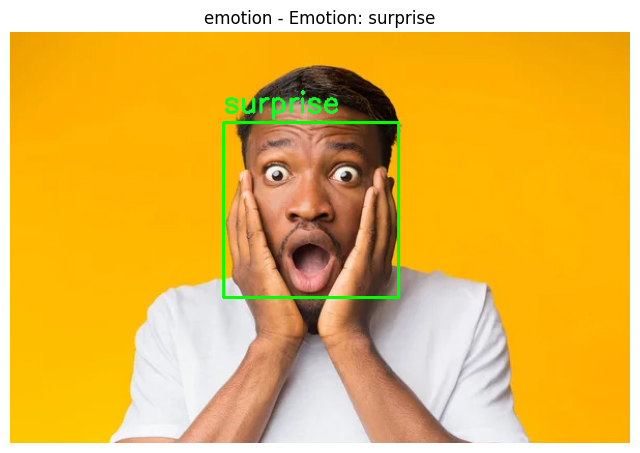

In [8]:
base_folder = "/kaggle/input/emotion"
mp_face_detection = mp.solutions.face_detection

# Iterate over each subfolder
for subfolder in os.listdir(base_folder):
    subfolder_path = os.path.join(base_folder, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    # Get image files in subfolder
    image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(image_files) < 8:
        print(f"Not enough images in {subfolder}")
        continue

    filename = image_files[0]
    img_path = os.path.join(subfolder_path, filename)

    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load {filename} in {subfolder}")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.4) as face_detection:
        results = face_detection.process(img_rgb)

    if results.detections:
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            h, w, _ = img.shape
            x = int(bboxC.xmin * w)
            y = int(bboxC.ymin * h)
            bw = int(bboxC.width * w)
            bh = int(bboxC.height * h)

            # Clamp coordinates
            x = max(0, x)
            y = max(0, y)
            bw = min(w - x, bw)
            bh = min(h - y, bh)

            face_crop = img[y:y + bh, x:x + bw]

            try:
                result = DeepFace.analyze(face_crop, actions=['emotion'], enforce_detection=False)
                emotion = result[0]['dominant_emotion']

    # 🎯 Nicely formatted emotion report
                print(f"\nDeepFace Emotion Report for {filename} in {subfolder}:")
                emotions = result[0]['emotion']
                for emo, score in emotions.items():
                    print(f"  {emo.capitalize():<12}: {score:.2f}%")
                print(f"Dominant Emotion : {emotion}\n")

            except Exception as e:
                print(f"Emotion detection failed on {filename} in {subfolder}: {e}")
                emotion = "Unknown"
            # Draw bounding box and label
            cv2.rectangle(img, (x, y), (x + bw, y + bh), (0, 255, 0), 2)
            cv2.putText(img, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
    else:
        print(f"No face detected in {filename} of {subfolder}")
        continue

    # Convert for display
    img_rgb_disp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb_disp)
    plt.axis('off')
    plt.title(f"{subfolder} - Emotion: {emotion}")
    plt.show()

## 🔍 EmotionPredictor Class

The `EmotionPredictor` class is the core of the multi-modal emotion recognition system. It fuses deep learning-based predictions with hand-crafted heuristic rules to produce a robust emotion classification for each video frame.

---

### 🧠 Supported Emotion Labels

```python
['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


In [5]:
class EmotionPredictor:
    # Define emotion labels aligning with DeepFace's output
    EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    
    def __init__(self, window_size=5, deep_weight=0.7, heuristic_weight=0.3):
        self.window_size = window_size
        self.deep_weight = deep_weight
        self.heuristic_weight = heuristic_weight
        self.history = deque(maxlen=window_size)
        
    @staticmethod
    def euclidean_dist(p1, p2):
        return math.dist(p1, p2)
    
    @staticmethod
    def get_point(landmarks, idx, w, h):
        pts = landmarks.landmark if hasattr(landmarks, 'landmark') else landmarks
        lm = pts[idx]
        return (lm.x * w, lm.y * h)
    
    @staticmethod
    def get_face_bbox(face_landmarks, w, h):
        pts = face_landmarks.landmark if hasattr(face_landmarks, 'landmark') else face_landmarks
        xs = [lm.x * w for lm in pts]
        ys = [lm.y * h for lm in pts]
        return min(xs), max(xs), min(ys), max(ys)
    
    @staticmethod
    def get_hand_states(hand_landmarks, face_landmarks, w, h):
        states = {
            'over_head': False,
            'near_face': False,
            'under_head': False,
            'on_body': False
        }
        
        if not hand_landmarks or not face_landmarks:
            return states
        
        # Get key face points
        head_top_y = EmotionPredictor.get_point(face_landmarks, 10, w, h)[1]
        chin_y = EmotionPredictor.get_point(face_landmarks, 152, w, h)[1]
        left_cheek_x = EmotionPredictor.get_point(face_landmarks, 234, w, h)[0]
        right_cheek_x = EmotionPredictor.get_point(face_landmarks, 454, w, h)[0]
        
        # Calculate dynamic thresholds based on face size
        face_height = abs(chin_y - head_top_y)
        over_head_threshold = 0.15 * face_height  
        
        # Get face bounding box
        x_min, x_max, y_min, y_max = EmotionPredictor.get_face_bbox(face_landmarks, w, h)
        body_x_min = min(left_cheek_x, right_cheek_x)
        body_x_max = max(left_cheek_x, right_cheek_x)
        
        for hand in hand_landmarks:
            hand_points = [(lm.x * w, lm.y * h) for lm in hand.landmark]
            hand_x = [p[0] for p in hand_points]
            hand_y = [p[1] for p in hand_points]
            
            # 1. Check over_head 
            if all(y < head_top_y - over_head_threshold for y in hand_y):
                states['over_head'] = True
                continue
            
            # 2. Check near_face
            if any(x_min <= x <= x_max and y_min <= y <= y_max for x, y in hand_points):
                states['near_face'] = True
                continue
            
            # 3. Check on_body
            if all(y > chin_y and body_x_min <= x <= body_x_max for x, y in hand_points):
                states['on_body'] = True
                continue
            
            # 4. Check under_head
            if all(y > chin_y for y in hand_y):
                states['under_head'] = True
        
        return states
    
    @staticmethod
    def is_fist(hand_landmark_obj, face_landmarks, w, h, threshold=30):
        # First check if hand is overhead or near face
        hand_states = EmotionPredictor.get_hand_states([hand_landmark_obj], face_landmarks, w, h)
        if hand_states['over_head'] or hand_states['near_face']:
            return False
        
        landmarks = hand_landmark_obj.landmark
        tip_pip_pairs = [(8, 6), (12, 10), (16, 14), (20, 18)]
        
        curled = sum(
            1 for tip, pip in tip_pip_pairs
            if EmotionPredictor.euclidean_dist(
                EmotionPredictor.get_point(landmarks, tip, w, h),
                EmotionPredictor.get_point(landmarks, pip, w, h)
            ) < threshold
        )
        return curled >= 3
    
    def predict_heuristic(self, face_landmarks, hand_landmarks, w, h):
        def get(idx): 
            return self.get_point(face_landmarks, idx, w, h)
        
        # Facial metrics
        le_top, le_bot = get(159), get(145)
        re_top, re_bot = get(386), get(374)
        mt, mb = get(13), get(14)
        ml, mr = get(61), get(291)
        lbi, lbo = get(70), get(105)
        
        eye_open = (self.euclidean_dist(le_top, le_bot) + 
                    self.euclidean_dist(re_top, re_bot)) / 2
        mouth_open = self.euclidean_dist(mt, mb)
        w_mouth = self.euclidean_dist(ml, mr) or 1  
        mouth_aspect = mouth_open / w_mouth
        eye_ratio = eye_open / w_mouth
        brow_angle = abs(lbi[1] - lbo[1]) / w_mouth

        # Get unified hand states
        hand_states = self.get_hand_states(hand_landmarks, face_landmarks, w, h)
        
        # Detect fist 
        fist_detected = False
        if hand_landmarks:
            for hand in hand_landmarks:
                if not self.get_hand_states([hand], face_landmarks, w, h)['over_head']:
                    if self.is_fist(hand, face_landmarks, w, h):
                        fist_detected = True
                        break

        # Initialize scores 
        scores = {e: 0 for e in self.EMOTIONS}
        scores['neutral'] = 0.5  # Baseline
        
        # Facial expressions
        if 0.18 < mouth_aspect < 0.5:
            scores['happy'] += 1
        
        if mouth_aspect < 0.25 and eye_ratio < 0.15:
            scores['sad'] += 2
        
        if mouth_aspect > 0.45:
            scores['surprise'] += 2
            scores['fear'] += 1
            if eye_ratio > 0.3:
                scores['surprise'] += 0.5
            else :
                scores['fear'] += 0.5
        
        if brow_angle > 0.10:
            scores['angry'] += 1

        # Hand states
        if hand_states['over_head']:
            scores['surprise'] += 1.2
        elif hand_states['near_face']:
            scores['surprise'] += 0.8
            scores['fear'] += 0.5

        # Fist detection
        if fist_detected:
            if hand_states['on_body'] or hand_states['under_head']:
                scores['fear'] += 2
            elif hand_states['near_face'] and eye_ratio > 0.25:
                scores['fear'] += 1.8
            else:
                scores['angry'] += 2   
        return scores
    
    def predict_deep(self, img, *_args, **_kwargs):
        try:
            # Convert to RGB for MediaPipe and DeepFace
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape

            # Detect face using MediaPipe FaceDetection
            with mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.4) as face_detection:
                results = face_detection.process(img_rgb)

            if not results.detections:
                raise ValueError("No face detected")

        # Use the first detected face
            detection = results.detections[0]
            bboxC = detection.location_data.relative_bounding_box
            x = int(bboxC.xmin * w)
            y = int(bboxC.ymin * h)
            bw = int(bboxC.width * w)
            bh = int(bboxC.height * h)

        # Clamp bounding box to image dimensions
            x = max(0, x)
            y = max(0, y)
            bw = min(w - x, bw)
            bh = min(h - y, bh)

        # Crop face
            face_crop = img[y:y + bh, x:x + bw]
            if face_crop.size == 0:
                raise ValueError("Invalid crop size")

        # DeepFace emotion analysis
            result = DeepFace.analyze(face_crop, actions=['emotion'], enforce_detection=False, silent=True)

        # Handle output
            if isinstance(result, list):
                emotions = result[0].get('emotion', {})
            else:
                emotions = result.get('emotion', {})

            if not emotions:
                raise ValueError("DeepFace returned no emotions")

            total = sum(emotions.values())
            if total == 0:
                raise ValueError("Emotion scores sum to zero")

        # Normalize to probabilities aligned with EMOTIONS list
            return {e: emotions.get(e, 0) / total for e in self.EMOTIONS}

        except Exception as e:
            print(f"DeepFace error: {e}")
        # Fallback: return uniform distribution
            return {e: 1 / len(self.EMOTIONS) for e in self.EMOTIONS}



    
    
    def predict_frame(self, img, face_landmarks, hand_landmarks, w, h):
        # Get predictions from both models
        deep_probs = self.predict_deep(img, face_landmarks, w, h)
        heuristic_scores = self.predict_heuristic(face_landmarks, hand_landmarks, w, h)
    
        # Normalize heuristic scores to probabilities
        heuristic_total = sum(heuristic_scores.values()) or 1e-6  # Avoid division by zero
        heuristic_probs = {e: score / heuristic_total for e, score in heuristic_scores.items()}
    
        # Combine predictions
        combined = {}
        for e in self.EMOTIONS:
            combined[e] = (
                self.deep_weight * deep_probs[e] + 
                self.heuristic_weight * heuristic_probs[e]
            )
    
        # Return final prediction based on combined probabilities
        return max(combined, key=combined.get)


## 🖼️ Image Processing and Emotion Prediction

This section of the pipeline loads images from a directory, extracts landmarks using MediaPipe, and predicts emotions using the `EmotionPredictor` class. It also visualizes the results and prints detailed debug information.

---

W0000 00:00:1753989272.612400     132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989272.632578     134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989272.647532     134 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
W0000 00:00:1753989272.682316     135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989272.724034     135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989272.798721     142 inference_feedback_manager.

25-07-31 19:14:33 - 🔗 facial_expression_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5 to /root/.deepface/weights/facial_expression_model_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 149MB/s]
W0000 00:00:1753989273.783772     153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


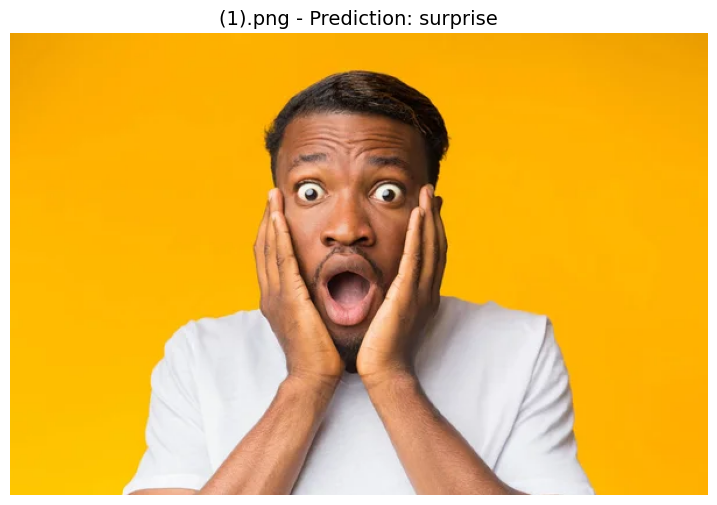


📷 (1).png | Final Predicted Emotion: surprise

🔍 DeepFace probabilities:
  angry     : 0.000
  disgust   : 0.000
  fear      : 0.001
  happy     : 0.000
  sad       : 0.000
  surprise  : 0.999
  neutral   : 0.000

🧠 Heuristic probabilities:
  angry     : 0.137
  disgust   : 0.000
  fear      : 0.274
  happy     : 0.137
  sad       : 0.000
  surprise  : 0.384
  neutral   : 0.068

⚖️ Combined weighted probabilities:
  angry     : 0.041
  disgust   : 0.000
  fear      : 0.083
  happy     : 0.041
  sad       : 0.000
  surprise  : 0.814
  neutral   : 0.021


W0000 00:00:1753989274.317564     160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989274.532757     165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


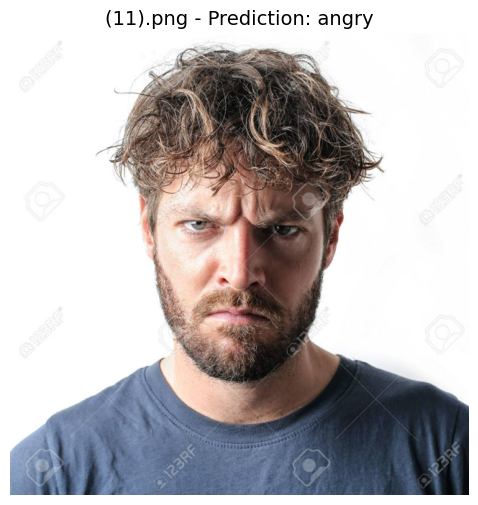


📷 (11).png | Final Predicted Emotion: angry

🔍 DeepFace probabilities:
  angry     : 0.577
  disgust   : 0.000
  fear      : 0.001
  happy     : 0.000
  sad       : 0.282
  surprise  : 0.000
  neutral   : 0.140

🧠 Heuristic probabilities:
  angry     : 0.667
  disgust   : 0.000
  fear      : 0.000
  happy     : 0.000
  sad       : 0.000
  surprise  : 0.000
  neutral   : 0.333

⚖️ Combined weighted probabilities:
  angry     : 0.604
  disgust   : 0.000
  fear      : 0.000
  happy     : 0.000
  sad       : 0.198
  surprise  : 0.000
  neutral   : 0.198


W0000 00:00:1753989275.010433     169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989275.100471     172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


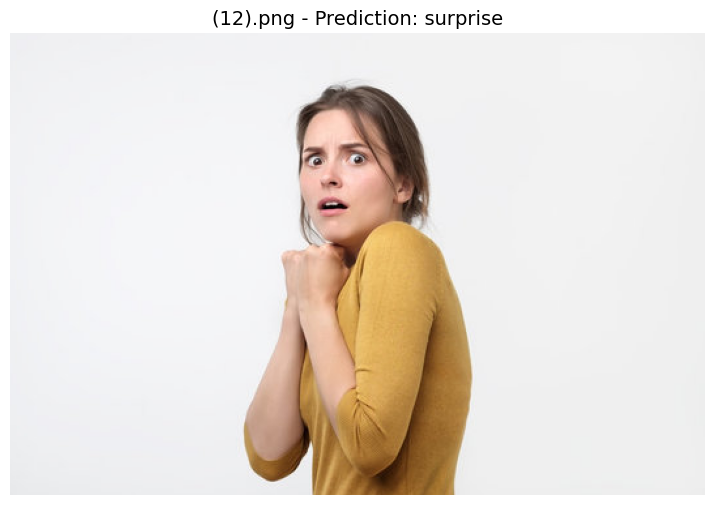


📷 (12).png | Final Predicted Emotion: surprise

🔍 DeepFace probabilities:
  angry     : 0.000
  disgust   : 0.000
  fear      : 0.014
  happy     : 0.000
  sad       : 0.000
  surprise  : 0.986
  neutral   : 0.000

🧠 Heuristic probabilities:
  angry     : 0.222
  disgust   : 0.000
  fear      : 0.444
  happy     : 0.222
  sad       : 0.000
  surprise  : 0.000
  neutral   : 0.111

⚖️ Combined weighted probabilities:
  angry     : 0.067
  disgust   : 0.000
  fear      : 0.143
  happy     : 0.067
  sad       : 0.000
  surprise  : 0.690
  neutral   : 0.033


W0000 00:00:1753989275.433918     177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989275.515462     181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


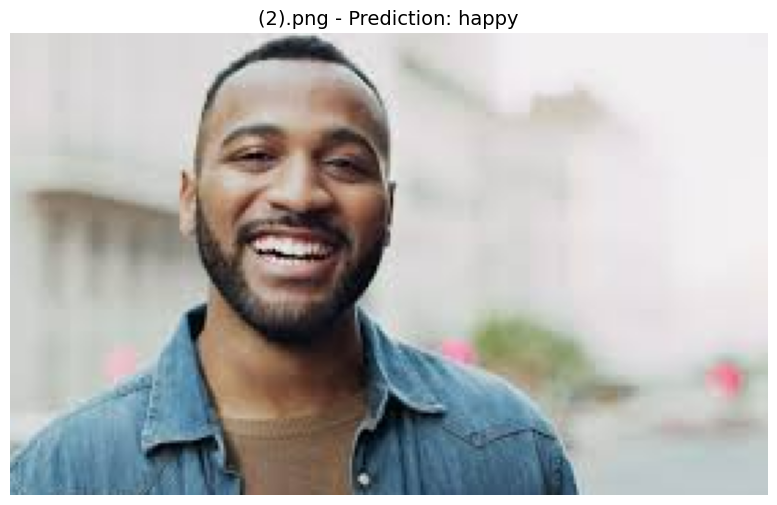


📷 (2).png | Final Predicted Emotion: happy

🔍 DeepFace probabilities:
  angry     : 0.000
  disgust   : 0.000
  fear      : 0.000
  happy     : 0.998
  sad       : 0.000
  surprise  : 0.000
  neutral   : 0.002

🧠 Heuristic probabilities:
  angry     : 0.222
  disgust   : 0.000
  fear      : 0.000
  happy     : 0.222
  sad       : 0.444
  surprise  : 0.000
  neutral   : 0.111

⚖️ Combined weighted probabilities:
  angry     : 0.067
  disgust   : 0.000
  fear      : 0.000
  happy     : 0.765
  sad       : 0.133
  surprise  : 0.000
  neutral   : 0.035


W0000 00:00:1753989275.925889     185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989276.004457     188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


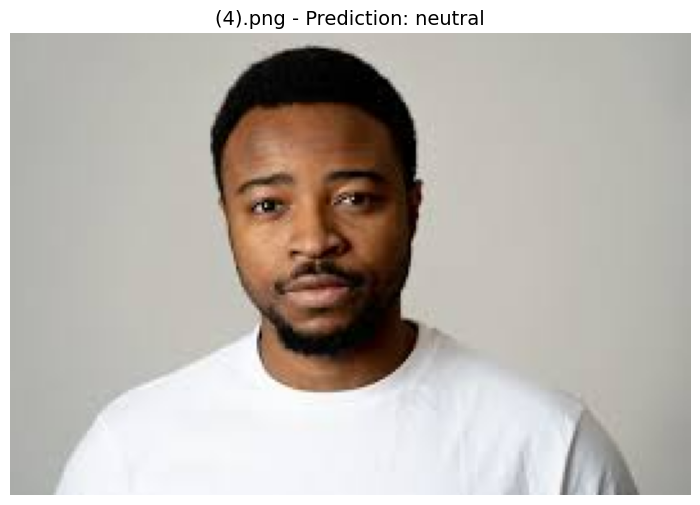


📷 (4).png | Final Predicted Emotion: neutral

🔍 DeepFace probabilities:
  angry     : 0.001
  disgust   : 0.000
  fear      : 0.010
  happy     : 0.029
  sad       : 0.011
  surprise  : 0.000
  neutral   : 0.949

🧠 Heuristic probabilities:
  angry     : 0.286
  disgust   : 0.000
  fear      : 0.000
  happy     : 0.000
  sad       : 0.571
  surprise  : 0.000
  neutral   : 0.143

⚖️ Combined weighted probabilities:
  angry     : 0.086
  disgust   : 0.000
  fear      : 0.007
  happy     : 0.020
  sad       : 0.179
  surprise  : 0.000
  neutral   : 0.707


W0000 00:00:1753989276.377041     193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989276.553827     197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


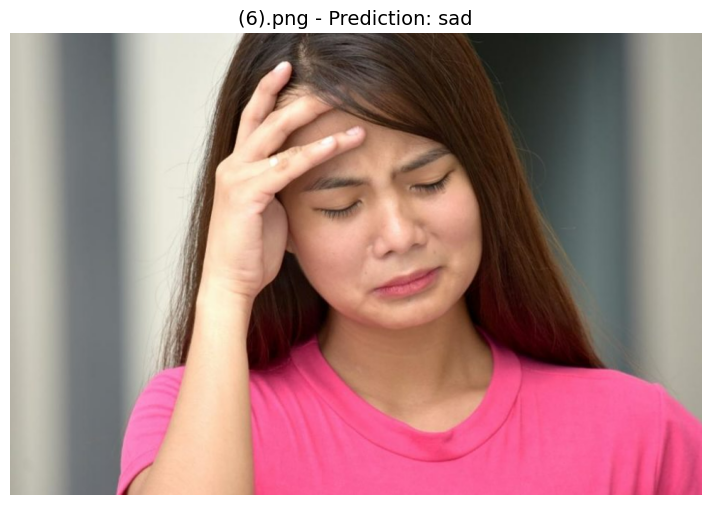


📷 (6).png | Final Predicted Emotion: sad

🔍 DeepFace probabilities:
  angry     : 0.027
  disgust   : 0.000
  fear      : 0.098
  happy     : 0.000
  sad       : 0.871
  surprise  : 0.000
  neutral   : 0.004

🧠 Heuristic probabilities:
  angry     : 0.208
  disgust   : 0.000
  fear      : 0.104
  happy     : 0.000
  sad       : 0.417
  surprise  : 0.167
  neutral   : 0.104

⚖️ Combined weighted probabilities:
  angry     : 0.082
  disgust   : 0.000
  fear      : 0.100
  happy     : 0.000
  sad       : 0.734
  surprise  : 0.050
  neutral   : 0.034


W0000 00:00:1753989277.154974     201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989277.379439     204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


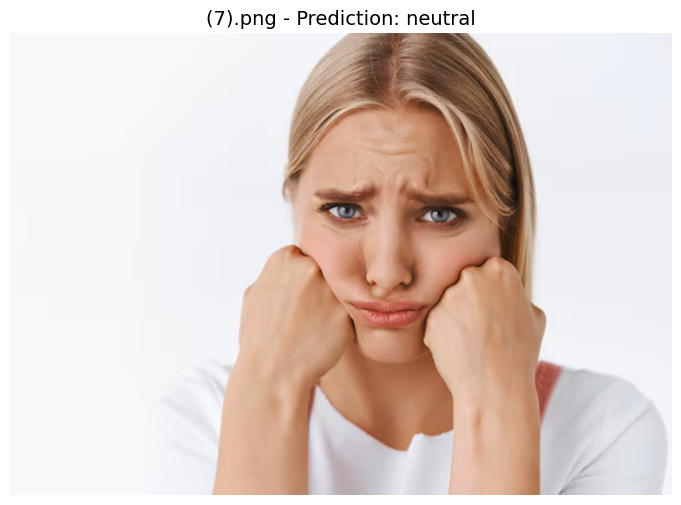


📷 (7).png | Final Predicted Emotion: neutral

🔍 DeepFace probabilities:
  angry     : 0.016
  disgust   : 0.000
  fear      : 0.043
  happy     : 0.001
  sad       : 0.258
  surprise  : 0.001
  neutral   : 0.682

🧠 Heuristic probabilities:
  angry     : 0.000
  disgust   : 0.000
  fear      : 0.278
  happy     : 0.000
  sad       : 0.000
  surprise  : 0.444
  neutral   : 0.278

⚖️ Combined weighted probabilities:
  angry     : 0.011
  disgust   : 0.000
  fear      : 0.114
  happy     : 0.000
  sad       : 0.180
  surprise  : 0.134
  neutral   : 0.561
DeepFace error: No face detected
DeepFace error: No face detected


W0000 00:00:1753989277.897843     209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989277.941048     213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


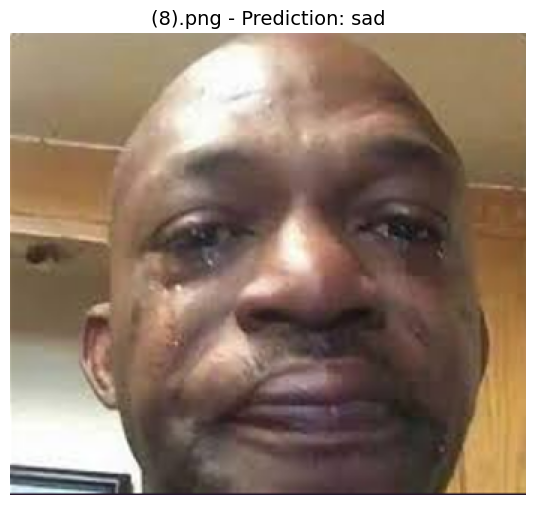


📷 (8).png | Final Predicted Emotion: sad

🔍 DeepFace probabilities:
  angry     : 0.143
  disgust   : 0.143
  fear      : 0.143
  happy     : 0.143
  sad       : 0.143
  surprise  : 0.143
  neutral   : 0.143

🧠 Heuristic probabilities:
  angry     : 0.286
  disgust   : 0.000
  fear      : 0.000
  happy     : 0.000
  sad       : 0.571
  surprise  : 0.000
  neutral   : 0.143

⚖️ Combined weighted probabilities:
  angry     : 0.186
  disgust   : 0.100
  fear      : 0.100
  happy     : 0.100
  sad       : 0.271
  surprise  : 0.100
  neutral   : 0.143


W0000 00:00:1753989278.321469     217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989278.440435     221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


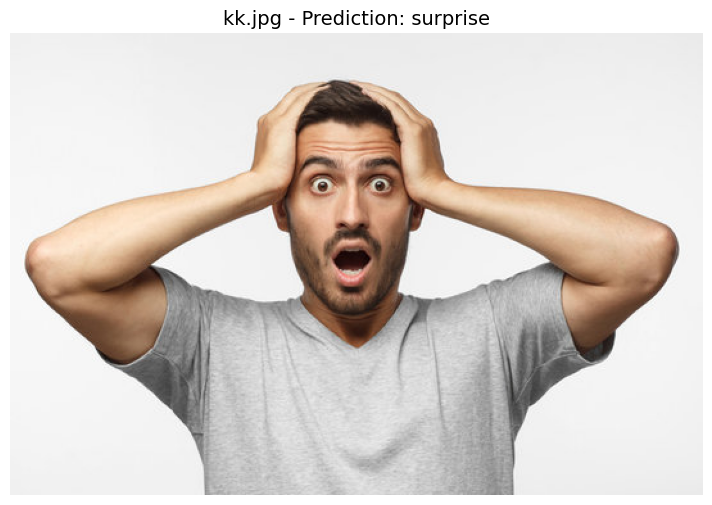


📷 kk.jpg | Final Predicted Emotion: surprise

🔍 DeepFace probabilities:
  angry     : 0.000
  disgust   : 0.000
  fear      : 0.000
  happy     : 0.000
  sad       : 0.000
  surprise  : 1.000
  neutral   : 0.000

🧠 Heuristic probabilities:
  angry     : 0.429
  disgust   : 0.000
  fear      : 0.214
  happy     : 0.000
  sad       : 0.000
  surprise  : 0.286
  neutral   : 0.071

⚖️ Combined weighted probabilities:
  angry     : 0.129
  disgust   : 0.000
  fear      : 0.064
  happy     : 0.000
  sad       : 0.000
  surprise  : 0.786
  neutral   : 0.021


W0000 00:00:1753989278.885182     225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753989279.049103     229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


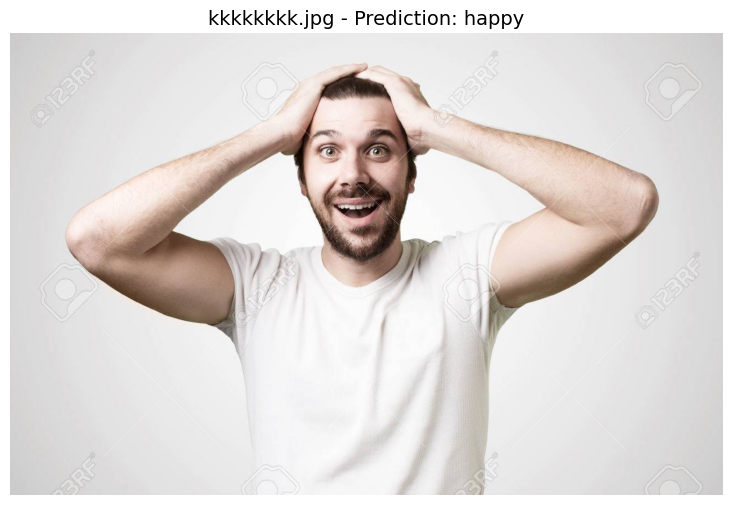


📷 kkkkkkkk.jpg | Final Predicted Emotion: happy

🔍 DeepFace probabilities:
  angry     : 0.000
  disgust   : 0.000
  fear      : 0.000
  happy     : 1.000
  sad       : 0.000
  surprise  : 0.000
  neutral   : 0.000

🧠 Heuristic probabilities:
  angry     : 0.263
  disgust   : 0.000
  fear      : 0.132
  happy     : 0.263
  sad       : 0.000
  surprise  : 0.211
  neutral   : 0.132

⚖️ Combined weighted probabilities:
  angry     : 0.079
  disgust   : 0.000
  fear      : 0.039
  happy     : 0.779
  sad       : 0.000
  surprise  : 0.063
  neutral   : 0.039


In [6]:
# Initialize mediapipe and predictor
mp_face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)
mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=2)
predictor = EmotionPredictor()

# Directory of images
img_dir = '/kaggle/input/emotion/emotion'

# Loop through images
for filename in sorted(os.listdir(img_dir)):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img_path = os.path.join(img_dir, filename)
    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w, _ = img.shape
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Face landmarks
    face_result = mp_face_mesh.process(img_rgb)
    if not face_result.multi_face_landmarks:
        print(f"[{filename}] No face detected.")
        continue
    face_landmarks = face_result.multi_face_landmarks[0]

    # Hand landmarks
    hand_result = mp_hands.process(img_rgb)
    hand_landmarks = hand_result.multi_hand_landmarks if hand_result.multi_hand_landmarks else []

    # Prediction
    final_emotion = predictor.predict_frame(img, face_landmarks, hand_landmarks, w, h)

    # Get debug info
    deep_probs = predictor.predict_deep(img, face_landmarks, w, h)
    heuristic_scores = predictor.predict_heuristic(face_landmarks, hand_landmarks, w, h)
    heuristic_total = sum(heuristic_scores.values())
    heuristic_probs = {e: score / heuristic_total for e, score in heuristic_scores.items()}
    combined = {
        e: predictor.deep_weight * deep_probs[e] + predictor.heuristic_weight * heuristic_probs[e]
        for e in predictor.EMOTIONS
    }

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"{filename} - Prediction: {final_emotion}", fontsize=14)
    plt.show()

    print(f"\n📷 {filename} | Final Predicted Emotion: {final_emotion}")
    print("\n🔍 DeepFace probabilities:")
    for k, v in deep_probs.items():
        print(f"  {k:<10}: {v:.3f}")

    print("\n🧠 Heuristic probabilities:")
    for k, v in heuristic_probs.items():
        print(f"  {k:<10}: {v:.3f}")

    print("\n⚖️ Combined weighted probabilities:")
    for k, v in combined.items():
        print(f"  {k:<10}: {v:.3f}")